In [1]:
import pygmt
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
from pyproj import Transformer

# Plotting Function

In [8]:
# make function for a starting point for RIS plots
# default map extent is for Ross Ice Shelf
def start_fig(n = -1600e3, e = -860e3, s = -200e3, w = 670e3, subplots=False):
    global fig, fig_reg, fig_proj, fig_proj_ll, bardwidth, pos_str
    
    #set figure height, width and map scale
    fig_height = 180 # in mm
    fig_width = fig_height*(w-e)/(s-n)
    fig_ratio = (s-n)/(fig_height/1000)

    # Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
    fig_reg = f'{e}/{w}/{n}/{s}'
    fig_proj = f"x1:{fig_ratio}"
    fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

    # colorbar width and position
    barwidth = fig_width/10 * 0.8 # color bar width is 40% of the map width, in cm
    pos_str = f'jBC+w{barwidth}c/.5c+jTC+o0c/.2c+h+e'
    
    # initialize figure
    if subplots==False:
        fig = pygmt.Figure()
    # if adding a suplot, don't re-initialize, but move origin over    
    else:
        fig.shift_origin(xshift=fig_width/10)
    
    # add white background and frame
    fig.coast(region = fig_reg, projection = fig_proj_ll, land = 'white', water = 'white', 
              frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
    
    # plot groundingline and coastlines
    # fig.plot(projection=fig_proj, region=fig_reg,
    #         data=gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\GroundingLine_Antarctica_v02.shp'), 
    #         pen = '1.2p,black', verbose='e')
    # fig.plot(data=gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\Coastline_Antarctica_v02.shp'), 
    #         pen='1.2p,black', verbose='e')

    # plot graticules overtop, at 4d latitude and 30d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
        fig.basemap(projection = fig_proj_ll, frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
start_fig()

# ROSETTA-Ice data

In [ ]:
# get ROSETTA-Ice gravity data
# switch this to pooch!
file = "C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/rs_2019_grav.csv"
rosetta = pd.read_csv(file)

rosetta.rename(columns={'FAG_levelled':'FA'}, inplace=True)

rosetta_block = pygmt.blockmedian(data=rosetta[["x", "y", "FA"]], 
                                         spacing="1000+e", 
                                         region=fig_reg)
rosetta_grid = pygmt.surface(data=rosetta_block,
              spacing='1000+e', M='1c',
              region=fig_reg,) 
# !gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
# !gmt grdmath -Df layers/ROSETTA_gravity.nc RIS_mask.nc MUL = layers/ROSETTA_gravity.nc
# !gmt grdsample layers/ROSETTA_gravity.nc -Glayers/ROSETTA_gravity.nc -T
print(f'{len(rosetta.FA)=}')
print(f'{len(rosetta_block)=}')
print(f'{len(rosetta_grid)=}')

In [ ]:
# initialize figure but extend plot north into Ross Sea
# start_fig(n = -2200e3)

start_fig()

# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", grid=rosetta_grid)

# plot grid
fig.grdimage(projection = fig_proj,
             grid=rosetta_grid,
             cmap=True, nan_transparent=True)

# colorbar
with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap=True, position = pos_str, 
                 frame=['xa100f100+l"FA gravity (mGal)"'], verbose='e')     

fig.show() 

# Updated AntGG compilation

In [3]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea) 
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
# file ='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.dat'
file='/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity.dat'
antgg_update = pd.read_csv(file, delim_whitespace=True, 
                           skiprows=3, names=['id', 'lat', 'lon', 'FA', 'Err', 'DG', 'BA'])

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update['x'], antgg_update['y'] = transformer.transform(antgg_update.lat.tolist(), antgg_update.lon.tolist())

region = vd.get_region((antgg_update.x, antgg_update.y))
antgg_update.describe()

,id,lat,lon,FA,Err,DG,BA,x,y
count,348276.000000,348276.000000,348276.000000,348276.000000,348276.000000,348276.000000,348276.000000,3.482760e+05,3.482760e+05
mean,222439.400160,-69.840288,-0.192563,-2.697175,3.548024,1.488909,-32.612559,-3.633612e+02,8.344000e+01
std,111064.684586,7.034158,103.925276,27.980076,3.112447,25.843419,60.363350,1.665051e+06,1.665136e+06
min,311.000000,-89.907960,-180.000000,-237.560000,0.800000,-219.150000,-406.410000,-3.330001e+06,-3.330001e+06
25%,132748.250000,-74.768500,-90.181455,-18.940000,2.300000,-13.190000,-53.010000,-1.350000e+06,-1.340001e+06
50%,222442.500000,-68.570830,-0.190035,-3.320000,3.000000,0.590000,-11.620000,-3.980099e-11,1.031765e-10
75%,312122.250000,-63.897150,89.816508,12.060000,3.100000,15.040000,5.210000,1.340000e+06,1.342500e+06
max,444579.000000,-59.954690,179.827940,171.860000,20.600000,178.030000,164.610000,3.330001e+06,3.330001e+06


In [6]:
antgg_update = pygmt.blockmedian(antgg_update[["x", "y", "FA"]], 
                                         spacing="5000+e", 
                                         region=(-3330000, 3330000, -3330000, 3330000))

# antgg_update = antgg_update.set_index(['x', 'y'])

# antgg_update=antgg_update[~antgg_update.index.duplicated()]
# # # antgg_update.to_xarray()
# xr.Dataset.from_dataframe(antgg_update)

fname = 'gravity_data/ant4d_gravity_epsg_5k.nc'
pygmt.surface(data=antgg_update[['x','y','FA']], 
                            spacing=5000, 
                            region=(-3330000, 3330000, -3330000, 3330000),
                            M='2c',
                            outgrid=fname
                            )
# antgg_update_tif
# pygmt.grdfill(grid=antgg_update_grid, mode='n', L=True, region=fig_reg)#, outgrid=fname)

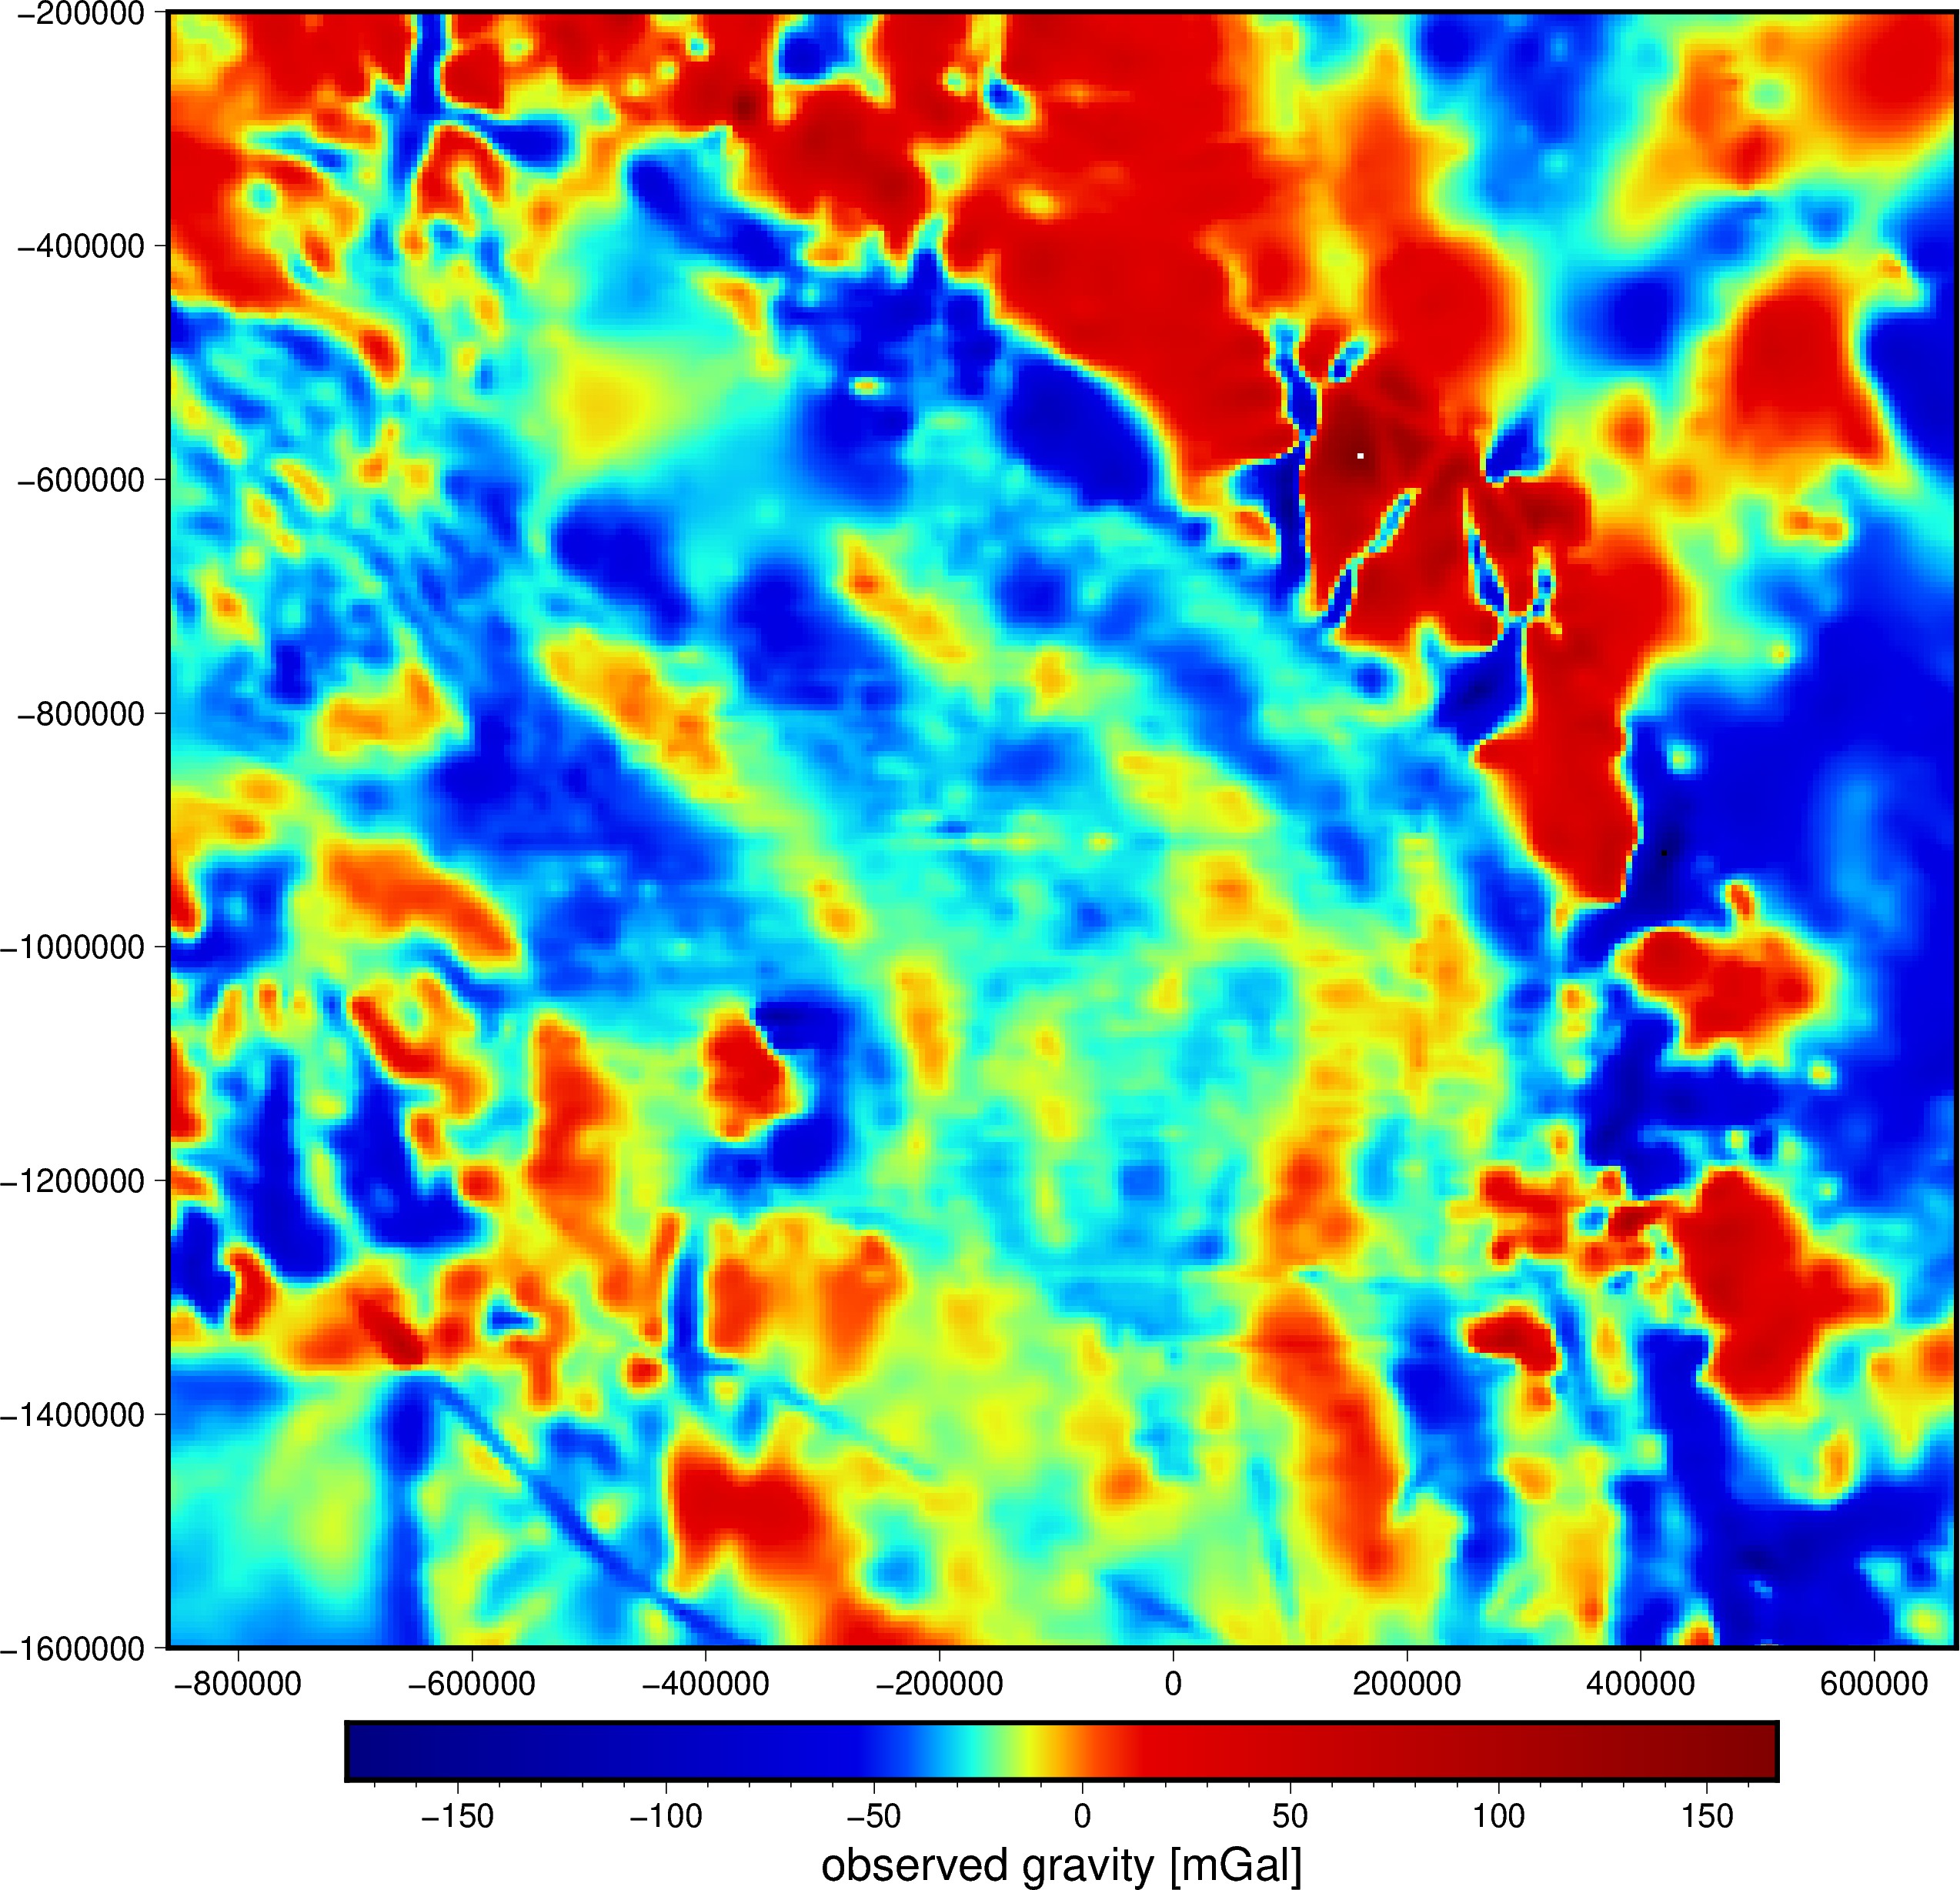

In [9]:
start_fig()
fname = '/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity_epsg_5k.nc'
# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", continuous=True, region=fig_reg, grid=fname)
# pygmt.makecpt(cmap="viridis", series=[antgg_update.FA.min(), antgg_update.FA.max()])

# plot grid      
fig.grdimage(grid=fname,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['a','+gwhite'],)

fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show() 

# Ground Surveys

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_KIS.csv'
KIS = pd.read_csv(file)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
KIS['x'], KIS['y'] = transformer.transform(KIS.Latitude.tolist(), KIS.Longitude.tolist())

KIS

In [ ]:
df=KIS
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

KIS['FA_shift']=KIS.FA+(df.FA.mean()-KIS.FA.mean())

In [ ]:
df=KIS
buffer=80e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

start_fig(n=n, s=s, e=e, w=w)


df=KIS
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_DD_2feb22.csv'
DD = pd.read_csv(file)
DD.drop(columns=['Free air anomaly', 'Free air effect'], inplace=True)
DD['FA']=DD['Absolute Gravity']-DD['Ellipsoidal gravity']+(DD.Elevation*0.3086)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
DD['x'], DD['y'] = transformer.transform(DD.Latitude.tolist(), DD.Longitude.tolist())
DD

In [ ]:
df=DD
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

DD['FA_shift']=DD.FA+(df.FA.mean()-DD.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=DD
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
fig_reg

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/wgz_fa.csv'
WGZ = pd.read_csv(file)
WGZ.rename(columns={'free-air_disturbance(mGal)':'FA', 'PSX(m)':'x', 'PSY(m)':'y'}, inplace=True)
# transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
# WGZ['x'], WGZ['y'] = transformer.transform(WGZ.Latitude.tolist(), WGZ.Longitude.tolist())
WGZ

In [ ]:
df=WGZ
buffer=20e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

WGZ['FA_shift']=WGZ.FA+(df.FA.mean()-WGZ.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=WGZ
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 